In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

In [2]:
data = pd.read_csv('data/my_PJME_MW.csv', index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


d:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


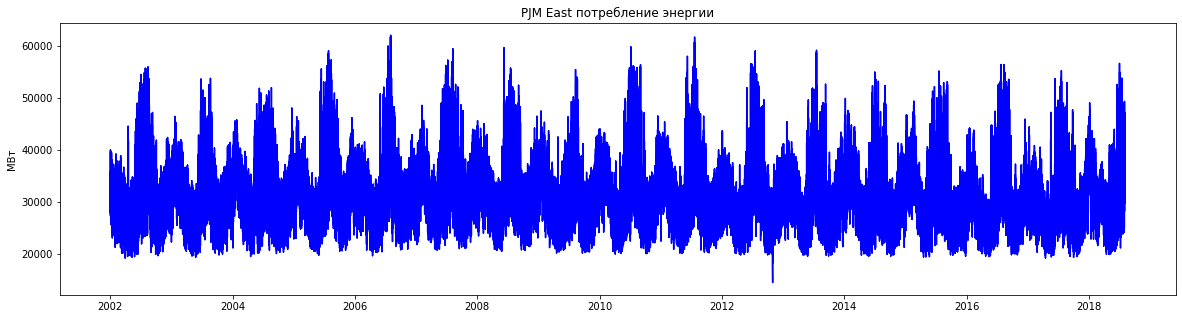

In [3]:
plt.figure(figsize =(20,5))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [5]:
data_m = data.resample('M').mean()

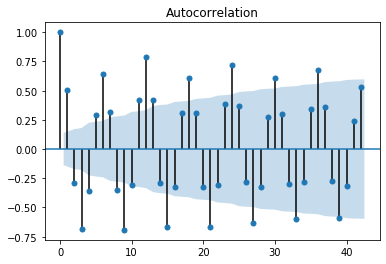

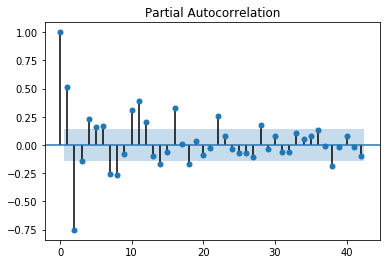

In [6]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=12*3.5)
plt.show()

sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=12*3.5)
plt.show()

Можно сказать что информация старше чем 3,25 г. не оказывает влияния на сегодняшнии значения при перерасчете данных по месячно

In [26]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q,
qs = 1
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs , 12] 

In [27]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [1, 1, 1, 12]


In [28]:
%%time
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[1, 1, 1, 12] - AIC:2640.8790629948617
Wall time: 885 ms


In [29]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 2, 2)x(1, 1, 1, 12)   Log Likelihood               -1314.440
Date:                            Tue, 21 Jan 2020   AIC                           2640.879
Time:                                    21:32:00   BIC                           2658.822
Sample:                                         0   HQIC                          2648.169
                                            - 176                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

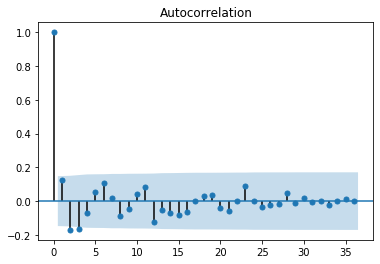

In [30]:
sm.graphics.tsa.plot_acf(results.resid, lags=36)
plt.show()

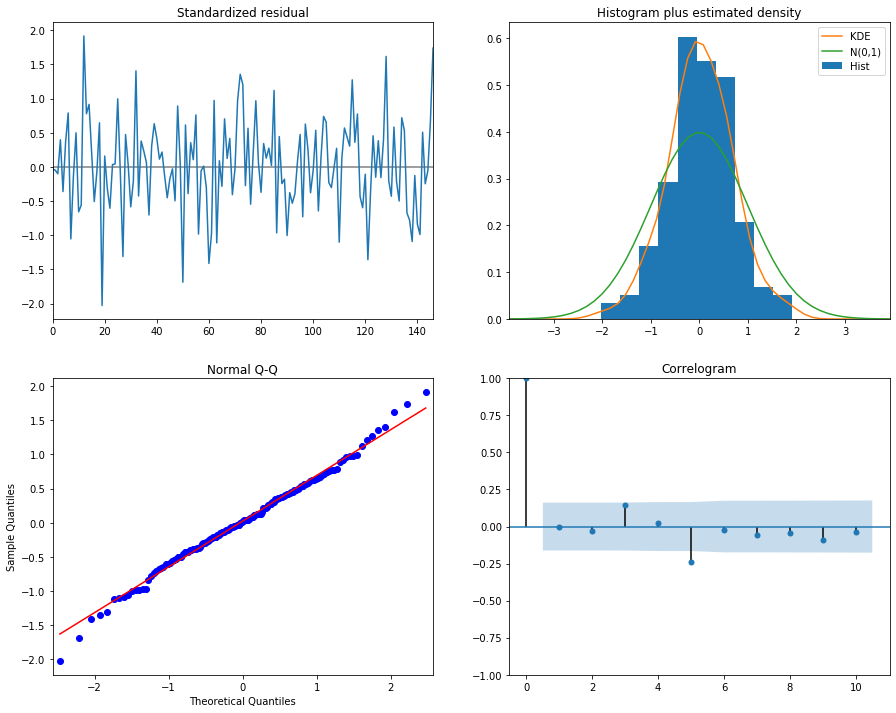

In [31]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [13]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [14]:
%%time
mas_result = []
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            mas_result.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4416.269672223332
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:4015.3605742791765
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:3714.4659328110406
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:3153.6893700282526
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2927.716207132725
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:2695.3223171841883
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:3105.220804461358
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:2919.473302993511
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:2583.226435511314
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:3175.9348958198534
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:3155.8921922748004
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:2907.0867482279664
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2936.813690293462
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2919.9376138675925
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2688.1556320921654
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:2839.18019891142
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:2808.62938374015
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:2562.245779738667
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:2938

ARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:2879.325423057995
ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:2828.0131117519595
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:2682.5618153305622
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:2670.369231202223
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:2620.5608210274013
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:2556.2231522223938
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:2506.6371445563536
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:2444.2210547187005
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:3602.6084557662834
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:3334.926125392096
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:3101.5081550567165
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:3328.531187794495
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:3052.108007046225
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:2825.236744217
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:3273.3175686291333
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:2901.8888903672128
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:2665.5350399184326
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:3313.8279810511694
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:32

ARIMA(1, 0, 2)x(1, 0, 2, 12) - AIC:2955.582864956455
ARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:2897.1284090458053
ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:2858.850319506687
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:2638.5311167887708
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:2803.418132572508
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:2746.2688451449526
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:2522.563895365599
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:2902.7853138559885
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:2993.3281073624867
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:2957.5209751077214
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:2665.5933060828593
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:2664.9415269738756
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:2633.596313259639
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:2534.1755191137354
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:2534.503454725921
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:2521.7156402968144
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:3546.4538282504063
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:3260.2005326747576
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC

ARIMA(1, 2, 2)x(0, 0, 2, 12) - AIC:2964.692972604074
ARIMA(1, 2, 2)x(0, 1, 0, 12) - AIC:3143.3208678906517
ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:2860.0715534934825
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:2647.1547364750086
ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:3083.172209199185
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:2781.5385890312873
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:2541.852306538054
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:3157.473151297364
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:3111.9545797407523
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:2887.0842182769347
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:2908.289435122333
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:2860.6049862404934
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:2647.758527932333
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:2817.138049373256
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:2777.154642320079
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:2543.4844082790005
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:2930.0533746006504
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:2923.585217776858
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:28

ARIMA(2, 1, 1)x(2, 1, 0, 12) - AIC:2648.9564400582294
ARIMA(2, 1, 1)x(2, 1, 1, 12) - AIC:2634.584587479836
ARIMA(2, 1, 1)x(2, 1, 2, 12) - AIC:2643.9626257565124
ARIMA(2, 1, 1)x(2, 2, 0, 12) - AIC:2522.4913531773404
ARIMA(2, 1, 1)x(2, 2, 1, 12) - AIC:2482.872315253352
ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:2459.894583727507
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:3327.616180605947
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:3077.3426675739884
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:2867.877914195362
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:3107.2936541383124
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:2831.890728634895
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:2630.5999685556
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:3061.9798426532548
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:2709.311569400435
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:2508.2105249656306
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:3097.03445200863
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:3041.7426129307933
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:2843.8321353750907
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:2886.

In [15]:
min(mas_result)

2438.8065320932105

ARIMA(2, 2, 2)x(2, 2, 0, 36) - AIC:535.4755285120671

In [22]:
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],order=[1,1,2],
                                seasonal_order=[1,2,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2225.930299177341


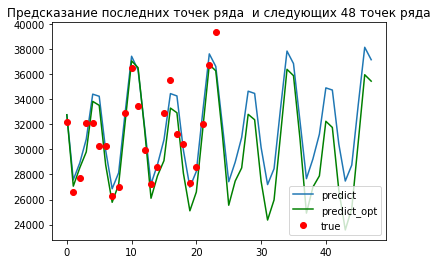

In [33]:
pred_dynamic = results.forecast(48)   
pred_dynamic_opt = results_opt.forecast(48)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt, 'g',  label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-24:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 48 точек ряда')
plt.legend()

plt.show()

Наш прогноз совпал с данными

In [34]:
from sklearn.metrics import r2_score 
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-6.913901193069484, 1.192986335057952e-09, 12, 163, {'1%': -3.471118535474365, '5%': -2.8794405060097024, '10%': -2.576313761526591}, 2932.54188309629)


In [35]:
results_opt.save('rez_model.h5') # и обратно t_rez = sm.load('rez_model.h5')

Вывод: недельная модель стала более точной по сравнению с дневной. Модели стали более сглаженные